# Prepare data and module

In [1]:
import pandas as pd
import numpy as np
import sklearn
from collections import defaultdict

In [2]:
ratings = pd.read_csv('./movie_data/u.data', sep='\t', header=None, names=['userId','movieId','rating','timestamp'])
ratings = ratings.drop('timestamp', axis=1)
ratings

,userId,movieId,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1
...,...,...,...
99995,880,476,3
99996,716,204,5
99997,276,1090,1
99998,13,225,2


In [3]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(ratings, test_size=0.2, random_state=1932)

In [4]:
movieIds = np.unique(train['movieId'])
userIds = np.unique(train['userId'])
print(f'movie 총 개수: {len(movieIds)}, user 총 수: {len(userIds)}')

1652


In [10]:
movieDict = defaultdict(dict) # [movieId][userId] = rating
userDict = defaultdict(dict) # [userId][movieId] = rating
userRatingMeanDict = defaultdict(dict) # [userId] = mean(rating)
movieRatingMeanDict = defaultdict(dict) # [movieId] = mean(rating)
coRatedMovieDict = defaultdict(dict) # [movieId1][movieId2] = [[movieId1r1, movieId1r2, ...], [movieId2r1, movieId2r2, ...]]
for i in train.index:
  userId = train._get_value(i, 'userId')
  movieId = train._get_value(i, 'movieId')
  rating = train._get_value(i, 'rating')
  movieDict[movieId][userId] = rating
  userDict[userId][movieId] = rating

for key in userDict.keys():
  userRatingMeanDict[key] = sum(userDict[key].values())/len(userDict[key].values())

for key in movieDict.keys():
  movieRatingMeanDict[key] = sum(movieDict[key].values())/len(movieDict[key].values())

for item1 in movieDict.keys():
  for item2 in movieDict.keys():
    if item1 == item2:
      continue
    d1 = movieDict[item1]
    d2 = movieDict[item2]
    coRatedMovieDict[item1][item2] = [[x, d1[x], d2[x]] for x in d1 if x in d2]


# cosine similarity

In [ ]:
def get_correlation_similarity(coRatedRi, coRatedRj):
  I = np.array(coRatedRi)
  J = np.array(coRatedRj)
  I_norm = np.sqrt(np.sum(np.square(I)))
  J_norm = np.sqrt(np.sum(np.square(J)))
  K = np.dot(I,J) / (I_norm * J_norm)
  return 0 if np.isnan(K) else K

In [11]:
cosineSimilarityDict = defaultdict(dict)
for item1 in movieDict.keys():
  for item2 in movieDict.keys():
    if item1 >= item2:
      continue
    numer = 0.
    denom1 = 0.
    denom2 = 0.
    for [userId, rating1, rating2] in coRatedMovieDict[item1][item2]:
      numer += rating1*rating2
      denom1 += rating1**2
      denom2 += rating2**2
    if numer*denom1*denom2==0:
      continue
    cosineSimilarityDict[item1][item2] = numer / ((denom1**0.5) * (denom2**0.5))
    cosineSimilarityDict[item2][item1] = cosineSimilarityDict[item1][item2]

In [ ]:
cosineSimilarityDict[1][2]

# correlation similarity

In [ ]:
def get_correlation_similarity(coRatedRi, coRatedRj):
  R_i = np.array(coRatedRi)
  R_j = np.array(coRatedRj)
  I = R_i-np.mean(R_i)
  J = R_j-np.mean(R_j)
  I_norm = np.sqrt(np.sum(np.square(I)))
  J_norm = np.sqrt(np.sum(np.square(J)))
  K = np.dot(I,J) / (I_norm * J_norm)
  return 0 if np.isnan(K) else K

In [8]:
correlationSimilarityDict = defaultdict(dict)
for item1 in movieDict.keys():
  for item2 in movieDict.keys():
    if item1 >= item2:
      continue
    numer = 0.
    denom1 = 0.
    denom2 = 0.
    for [userId, rating1, rating2] in coRatedMovieDict[item1][item2]:
      I = rating1-movieRatingMeanDict[item1]
      J = rating2-movieRatingMeanDict[item2]
      numer += I*J
      denom1 += I**2
      denom2 += J**2
    if numer*denom1*denom2==0:
      correlationSimilarityDict[item1][item2] = 0.
    else:
      correlationSimilarityDict[item1][item2] = numer / ((denom1**0.5) * (denom2**0.5))
    correlationSimilarityDict[item2][item1] = correlationSimilarityDict[item1][item2]

In [ ]:
correlationSimilarityDict[1][2]

# adjusted cosine similarity

In [ ]:
def get_adjusted_cosine_similarity(coRatedRi, coRatedRj, RuMean):
  R_i = np.array(coRatedRi)
  R_j = np.array(coRatedRj)
  I = R_i-RuMean
  J = R_j-RuMean
  I_norm = np.sqrt(np.sum(np.square(I)))
  J_norm = np.sqrt(np.sum(np.square(J)))
  K = np.dot(I,J) / (I_norm * J_norm)
  return K

In [9]:
adjustedCosineSimilarityDict = defaultdict(dict)
for item1 in movieDict.keys():
  for item2 in movieDict.keys():
    if item1 >= item2:
      continue
    numer = 0.
    denom1 = 0.
    denom2 = 0.
    for [userId, rating1, rating2] in coRatedMovieDict[item1][item2]:
      I = rating1-userRatingMeanDict[userId]
      J = rating2-userRatingMeanDict[userId]
      numer += I*J
      denom1 += I**2
      denom2 += J**2
    if numer*denom1*denom2==0:
      adjustedCosineSimilarityDict[item1][item2] = 0.
    else:
      adjustedCosineSimilarityDict[item1][item2] = numer / ((denom1**0.5) * (denom2**0.5))
    adjustedCosineSimilarityDict[item2][item1] = adjustedCosineSimilarityDict[item1][item2]

In [ ]:
adjustedCosineSimilarityDict[1][2]

# utils

In [12]:
similarityDicts = [cosineSimilarityDict, correlationSimilarityDict, adjustedCosineSimilarityDict]

In [13]:
def get_k_neighbor_dict(similarityDict, K):
  kSimilarityDict = defaultdict(dict)
  for i in movieIds:
    temp = sorted(similarityDict[i].items(), key=(lambda x:x[1]), reverse=True)
    if K != 0:
      temp = temp[:K]
    dict_ = {}
    for j in range(len(temp)):
        dict_[temp[j][0]] = temp[j][1]
    kSimilarityDict[i] = dict_
  return kSimilarityDict

In [14]:
kSimilarityDicts = [get_k_neighbor_dict(similarityDict, 0) for similarityDict in similarityDicts]

In [46]:
3.2=={}

False

In [50]:
# 각 item i의 가장 유사한 item N를 알아낸다
# 둘의 coRatedMovieDict[i][N]을 구한다
# regression을 돌려준다
from sklearn.linear_model import LinearRegression

regRatingDict = defaultdict(dict)
for i in movieIds:
  j=0
  for ksd in kSimilarityDicts:
    similarMovieId = list(ksd[i].keys())[0]
    if not coRatedMovieDict[i][similarMovieId]:
      continue
    users, Ri, Rn = np.array(coRatedMovieDict[i][similarMovieId]).T
    lineFitter = LinearRegression()
    lineFitter.fit(Ri.reshape(-1, 1), Rn)
    if userRatingMeanDict[i] == {}:
      continue
    regRatingDict[j][i] = lineFitter.predict([[userRatingMeanDict[i]]])
    j+=1

In [52]:
regRatingDict[0]

{1: array([3.68396226]),
 2: array([3.77358491]),
 3: array([2.68292683]),
 4: array([4.47058824]),
 5: array([3.]),
 6: array([3.61212121]),
 7: array([3.]),
 8: array([3.]),
 9: array([4.4375]),
 10: array([4.21621622]),
 11: array([3.46753247]),
 12: array([3.]),
 13: array([3.]),
 14: array([2.]),
 15: array([2.88095238]),
 16: array([4.27192982]),
 17: array([3.]),
 18: array([3.87012987]),
 19: array([3.5]),
 20: array([3.19444444]),
 21: array([3.]),
 22: array([3.37735849]),
 23: array([3.57142857]),
 24: array([4.29090909]),
 25: array([4.]),
 26: array([3.]),
 27: array([3.]),
 28: array([1.]),
 29: array([3.]),
 30: array([3.73333333]),
 31: array([3.]),
 32: array([3.26470588]),
 33: array([1.]),
 34: array([4.11764706]),
 35: array([3.]),
 36: array([4.]),
 37: array([3.65909091]),
 38: array([3.]),
 39: array([3.84210526]),
 40: array([2.92857143]),
 41: array([3.81081081]),
 42: array([3.68275862]),
 43: array([4.]),
 44: array([3.]),
 45: array([3.]),
 46: array([3.]),


In [ ]:
from sklearn.linear_model import LinearRegression

def get_regression_rating(R_i, R_N):
  X = np.concatenate((R_i['rating'].values, np.zeros(len(R_N['rating'].values))))
  y = np.concatenate((R_N['rating'].values, np.zeros(len(R_i['rating'].values))))
  line_fitter = LinearRegression()
  line_fitter.fit(X.reshape(-1,1), y)
  
  return line_fitter.predict([[np.sum(X) / np.count_nonzero(X < 1)]])

# prediction

In [15]:
def pred(u, i, kSimilarityDict):
  movieRatings = userDict[u] # [movieId] = rating
  movieSimilarity = kSimilarityDict[i] # [movieId] = similarity

  plus_mean = 0.
  if u in userRatingMeanDict:
    plus_mean = userRatingMeanDict[u]
  else:
    plus_mean = sum(userRatingMeanDict.items())/len(userRatingMeanDict.items())
  ratedSimilarMovie = [[movieRatings[x], movieSimilarity[x]] for x in movieRatings if x in movieSimilarity]
  
  similarityMulRating = list(map(lambda x: (x[0]-plus_mean)*x[1], ratedSimilarMovie))
  absoluteSimilarity = list(map(lambda x: abs(x[1]), ratedSimilarMovie))
  
  if sum(absoluteSimilarity)==0:
    return plus_mean
  p = sum(similarityMulRating)/sum(absoluteSimilarity)+plus_mean

  return min(max(p, 1.), 5.)

In [ ]:
pred(1, 1, kSimilarityDicts[1])

In [58]:
969 in regRatingDict[0]

False

In [59]:
def pred_reg(u, i, kSimilarityDict, regRatingDict):
  movieRatings = userDict[u] # [movieId] = rating
  movieSimilarity = kSimilarityDict[i] # [movieId] = similarity

  plus_mean = 0.
  if u in userRatingMeanDict:
    plus_mean = userRatingMeanDict[u]
  else:
    plus_mean = sum(userRatingMeanDict.items())/len(userRatingMeanDict.items())
  regRatings = []
  ratedSimilarMovie = [[regRatingDict[x] if x in regRatingDict else movieRatings[x], movieSimilarity[x]] for x in movieRatings if x in movieSimilarity]
  
  similarityMulRating = list(map(lambda x: (x[0]-plus_mean)*x[1], ratedSimilarMovie))
  absoluteSimilarity = list(map(lambda x: abs(x[1]), ratedSimilarMovie))
  
  if sum(absoluteSimilarity)==0:
    return plus_mean
  p = sum(similarityMulRating)/sum(absoluteSimilarity)+plus_mean

  return min(max(p, 1.), 5.)

In [ ]:
pred_reg(1, 3, 10, 'adjusted_cosine')

# evaluation

In [16]:
mae = []
for i in test.index:
  userId = test._get_value(i, 'userId')
  movieId = test._get_value(i, 'movieId')
  rating = test._get_value(i, 'rating')
  row = []
  for dic in kSimilarityDicts:
    p = pred(userId, movieId, dic)
    row.append(abs(p-rating))
  mae.append(row)

[0.83680257 0.81012093 0.75271649]


In [64]:
mae_reg = []
for i in test.index:
  userId = test._get_value(i, 'userId')
  movieId = test._get_value(i, 'movieId')
  rating = test._get_value(i, 'rating')
  row = []
  j=0
  for matrix in kSimilarityDicts:
    p = pred_reg(userId, movieId, dic, regRatingDict[j])
    row.append(abs(p-rating))
    j+=1
  mae_reg.append(row)

In [67]:
np.mean(mae_reg, axis=0)

[array([0.91493327]), array([0.93228701]), array([0.83623645])]

# visualization

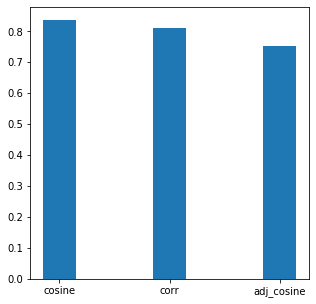

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.bar(['cosine','corr','adj_cosine'],np.mean(mae, axis=0),  width=0.3)
plt.show()

TypeError: only size-1 arrays can be converted to Python scalars

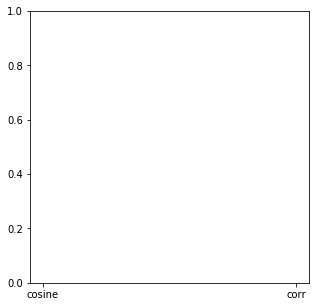

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.bar(['cosine','corr','adj_cosine'], np.mean(mae_reg, axis=0),  width=0.3)
plt.show()